# Import packages

In [1]:
import polars as pl
import polars.selectors as cs
import numpy as np
import src.plotting_functions as plotting
from importlib import reload
from src.utils import read_gtf, collapse_isoforms_to_proteoforms, read_SJ, gtf_to_SJ
from src.ryp import to_r, r
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt

Loading required package: svglite

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Transcript saturation

In [6]:
expression = pl.read_parquet("nextflow_results/V47/fulll_expression.parquet")

Text(0, 0.5, 'Number of high-confidence transcript models')

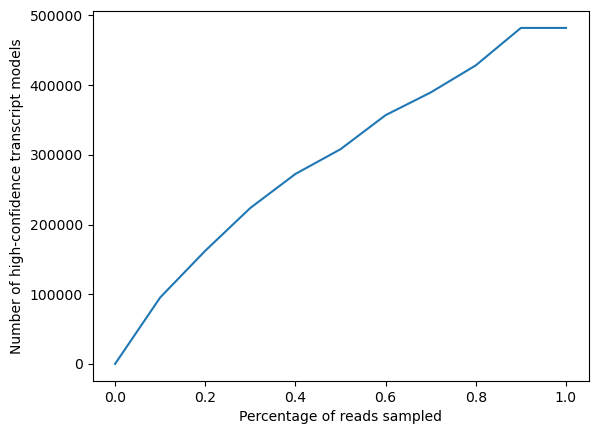

In [8]:
def get_n_isoforms(expression, percentage):
    return (expression.select( cs.numeric() )*percentage)\
        .with_columns(
            cs.all() > 5
        )\
        .filter(
            pl.sum_horizontal(cs.boolean()) > 2
        ).shape[0]    
x = np.arange(0, 1.1, 0.1)
y = [get_n_isoforms(expression, x) for x in x]
plt.plot(x, y)
plt.xlabel("Percentage of reads sampled")
plt.ylabel("Number of high-confidence transcript models")

# Short-read splice junction

## Load datasets

In [9]:
SR_SJ = pl.concat([read_SJ(file) for file in Path("STAR_results").rglob("*_SJ.out.tab")], how="vertical")\
    .unique(["chrom", "start", "end", "strand"])\
    .select(["chrom", "start", "end", "strand"])\
    .with_columns(
        strand = pl.col("strand").map_elements(lambda s: "+" if s == 1 else "-", return_dtype=pl.String)
    )\
    .with_columns(
        SR = pl.lit(True)
    )

LR_SJ = read_gtf("nextflow_results/V47/final_transcripts.gtf")\
    .pipe(gtf_to_SJ)

gencode_V47_SJ = read_gtf("".join([os.getenv("GENOMIC_DATA_DIR"), "/GENCODE/gencode.v47.annotation.gtf"]))\
    .filter(pl.col("feature") == "exon")\
    .pipe(gtf_to_SJ)    

In [10]:
LR_SJ_novel = LR_SJ\
    .filter(pl.col("start").is_null().not_())\
    .with_columns(
        LR = pl.lit(True)
    )\
    .join(
        gencode_V47_SJ["chrom", "start", "end", "strand"].with_columns(GENCODE=pl.lit(True)),
        on=["chrom", "start", "end", "strand"],
        how="full",
        coalesce = True
    )\
    .join(
        SR_SJ, on=["chrom", "start", "end", "strand"],
        how="full",
        coalesce = True
    )
LR_SJ_novel = LR_SJ_novel\
    .with_columns(
        pl.col("LR").fill_null(False),
        pl.col("GENCODE").fill_null(False),
        pl.col("SR").fill_null(False)
    )
to_r(LR_SJ_novel, "LR_SJ_novel")

## Venn diagram

null device 
          1 


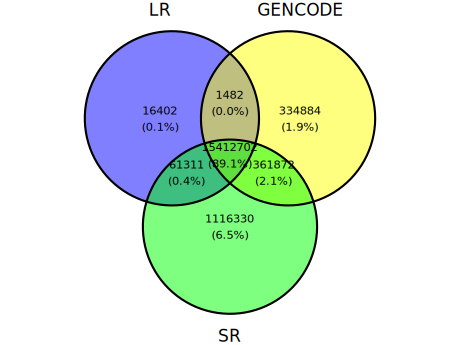

In [10]:
r(
    """
    library(ggvenn)
    ggvenn(
        LR_SJ_novel, c("LR", "GENCODE", "SR"),
        show_elements = FALSE
    )
    """
)


## Percentage of novel LR SJ validated by short-read SJ

In [ ]:
df = LR_SJ_novel\
    .filter(
        pl.col("GENCODE")==False
    )\
    .select(["LR", "SR"])\
    .with_columns(
        pl.col("SR").and_(pl.col("LR"))
    )\
    .rename({"LR": "long-read SJ", "SR": "long-read SJ validated\nby short-read"})\
    .sum()\
    .unpivot()

df = df\
    .with_columns(
        pl.col("value") / 77713
    )

Text(0.5, 0, '')

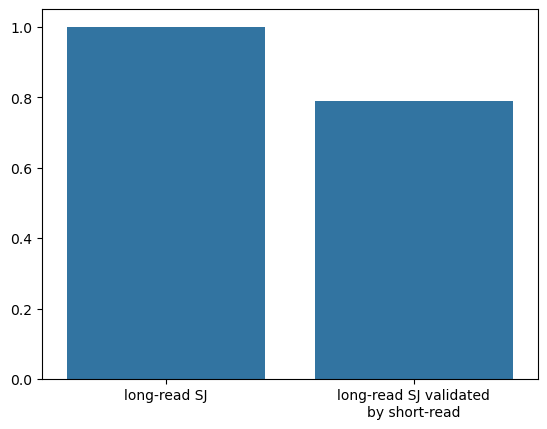

In [18]:
fig, ax = plt.subplots()
sns.barplot(data=df.to_pandas(), x="variable", y="value", ax = ax)
ax.set_ylabel("")
ax.set_xlabel("")

# Transcript Classification

## Load datasets

In [14]:
classification = pl.read_parquet("nextflow_results/V47/final_classification.parquet")
expression = pl.read_parquet("nextflow_results/V47/final_expression.parquet")

## Transcript classification histogram

In [31]:
reload(plotting)

<module 'src.plotting_functions' from '/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/src/plotting_functions.py'>

/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/src/plotting_functions.py:36: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("structural_category2").map_elements(lambda x: ...)
with this one instead:
  + pl.col("structural_category2").replace_strict(structural_category_labels)

  structural_category2 = pl.col("structural_category2").map_elements(lambda x: structural_category_labels[x])
/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/src/plotting_functions.py:35: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(


null device 
          1 


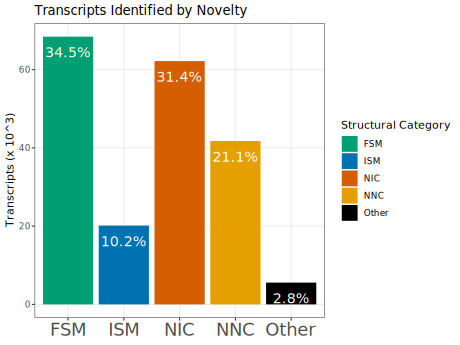

In [8]:
plotting.plot_transcript_class_hist(classification)

## Tanscript classification abundance

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


null device 
          1 


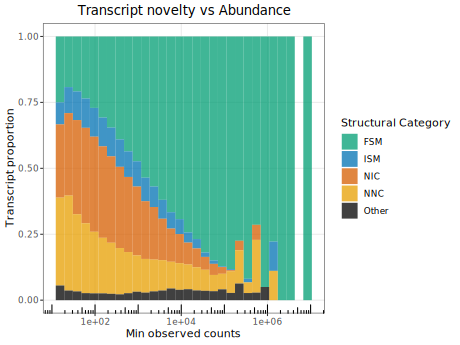

In [9]:
plotting.plot_transcript_class_abundance(classification, expression)

## Exon number vs transcript abundance

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


null device 
          1 


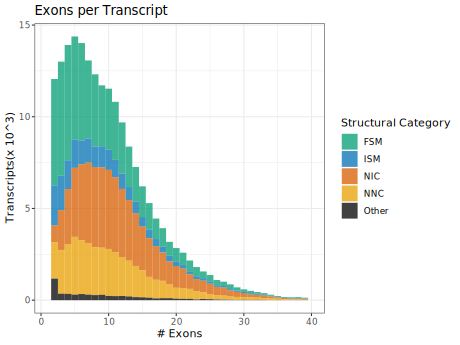

In [10]:
plotting.plot_nexon_vs_abundance(classification, expression)

## Plot transcript length vs abundance

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


null device 
          1 


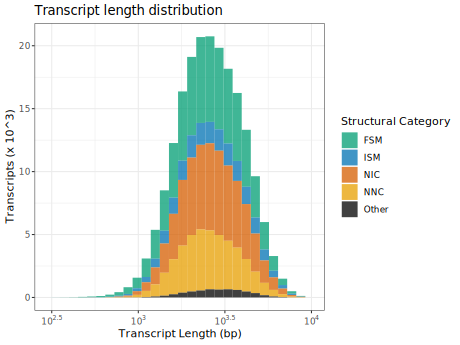

In [32]:
plotting.plot_len_vs_abundance(classification, expression)